In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
def generate_checkerboard(H=10, W=10):
    """Generate a symmetric checkerboard pattern as a torch tensor."""
    return torch.tensor(torch.arange(H) % 2).repeat(W, 1) ^ torch.tensor(torch.arange(H) % 2).repeat(W, 1).T

def generate_gradient(H=10, W=10):
    """Generate a linear gradient pattern as a torch tensor."""
    return torch.linspace(0, 1, W).repeat(H, 1)

def generate_radial_pattern(H=10, W=10):
    """Generate a radial gradient pattern as a torch tensor."""
    x, y = torch.meshgrid(torch.linspace(-1, 1, W), torch.linspace(-1, 1, H), indexing="xy")
    return torch.sqrt(x**2 + y**2)

def generate_spiral(H=10, W=10):
    """Generate a simple spiral pattern as a torch tensor."""
    x, y = torch.meshgrid(torch.linspace(-1, 1, W), torch.linspace(-1, 1, H), indexing="xy")
    return torch.sin(10 * torch.atan2(y, x))

def generate_noise(H=10, W=10):
    """Generate random noise pattern as a torch tensor."""
    return torch.rand(H, W)

def generate_even_distribution(size=10):
    """Generate a pattern with evenly spaced salient pixels."""
    pattern = torch.zeros(size, size)
    pattern[::2, ::2] = 1  # Every second pixel is highlighted
    return pattern

In [3]:
from composition import visualise_attn, softmax_normalization, z_normalization, minmax_normalization, gaussian_weighting
from composition import generate_grid, compute_divergence_and_curl, compute_gradients, compute_map_centroid
from composition import get_standard_normal, distance_to_line, get_grid_step_size

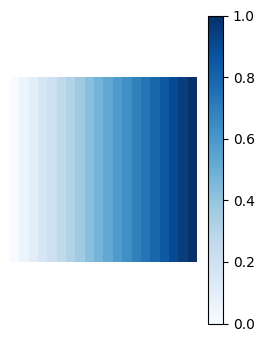

tensor(0.7311)


In [ ]:
H, W = 20, 20
attn_map = generate_gradient(H=H, W=W)
# attn_map = generate_radial_pattern(H=H, W=W)
visualise_attn(attn_map)

attn_map = attn_map.to(dtype=torch.float32)
attn_norm = minmax_normalization(attn_map)
# attn_norm = softmax_normalization(attn_map)
# attn_norm = z_normalization(attn_map)

# attn_prob = torch.exp(-(1 - attn_norm) / 2) # GAUSS METHOD
# attn_prob = torch.sigmoid(attn_norm)
attn_prob = attn_norm
gradients = compute_gradients(attn_prob, filter="sobel")
div, curl = compute_divergence_and_curl(gradients)

In [ ]:
positions = generate_grid(H, W, normalize=True, aspect_aware=True)
centroid = compute_map_centroid(attn_prob, positions, percentile=100)
print(centroid)

tensor([ 2.6571e-01, -2.3842e-08])


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def visualize_vector_field(grad_x, grad_y, divergence, curl, attn_map, step=5):
    """
    Visualizes gradient vectors, divergence, and curl as vector fields.
    
    Args:
        grad_x, grad_y: Gradient components.
        divergence, curl: Derived scalar fields.
        attn_map: Attention map for visualization.
        step: Subsampling step for quiver plot (higher = fewer arrows).
        scale: Scaling factor for arrow size.
        width: Width of quiver arrows.
    """
    H, W = grad_x.shape
    X, Y = np.meshgrid(np.arange(W), np.arange(H))  # Grid coordinates

    # Convert tensors to numpy
    grad_x_np, grad_y_np = grad_x.cpu().numpy(), grad_y.cpu().numpy()
    div_np, curl_np = divergence.cpu().numpy(), curl.cpu().numpy()
    attn_map_np = attn_map.cpu().numpy()  # Convert attention map

    magnitude = np.sqrt(grad_x_np**2 + grad_y_np**2)
    magnitude = magnitude / (magnitude.max() + 1e-5)  # Normalize to [0,1]

    max_mag = magnitude.max()
    if max_mag > 1e-5:
        grad_x_np /= max_mag
        grad_y_np /= max_mag

    fig, axes = plt.subplots(2, 3, figsize=(16, 8))  # Create 2x3 grid
    plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Adjust spacing

    # Subsample for better visibility
    X_sub, Y_sub = X[::step, ::step], Y[::step, ::step]
    grad_x_sub, grad_y_sub = grad_x_np[::step, ::step], grad_y_np[::step, ::step]
    mag_sub = magnitude[::step, ::step]

    # Gradient vector field with magnitude-based color
    q = axes[0, 0].quiver(X_sub, Y_sub, grad_x_sub, -grad_y_sub, mag_sub, cmap="Blues")
    axes[0, 0].set_title("Gradient Vector Field", fontsize=10)
    axes[0, 0].invert_yaxis()
    fig.colorbar(q, ax=axes[0, 0])

    # Divergence heatmap
    im1 = axes[0, 1].imshow(div_np, cmap='coolwarm', aspect='auto')
    axes[0, 1].set_title("Divergence Heatmap", fontsize=10)
    fig.colorbar(im1, ax=axes[0, 1])

    # Curl heatmap
    im2 = axes[0, 2].imshow(curl_np, cmap='coolwarm', aspect='auto')
    axes[0, 2].set_title("Curl Heatmap", fontsize=10)
    fig.colorbar(im2, ax=axes[0, 2])

    # Attention map heatmap
    im3 = axes[1, 0].imshow(attn_map_np, cmap="Blues", aspect='auto')
    axes[1, 0].set_title("Attention Map", fontsize=10)
    fig.colorbar(im3, ax=axes[1, 0])

    # Overlay quiver on divergence
    axes[1, 1].imshow(div_np, cmap='coolwarm', alpha=0.5, aspect='auto')  # Transparency
    q2 = axes[1, 1].quiver(X_sub, Y_sub, grad_x_sub, -grad_y_sub, mag_sub, cmap="Greys")
    axes[1, 1].set_title("Vector Field on Divergence", fontsize=10)
    axes[1, 1].invert_yaxis()
    fig.colorbar(q2, ax=axes[1, 1])

    # **Remove the empty subplot** (bottom-right) since we only have 5 plots
    fig.delaxes(axes[1, 2])

    plt.show()

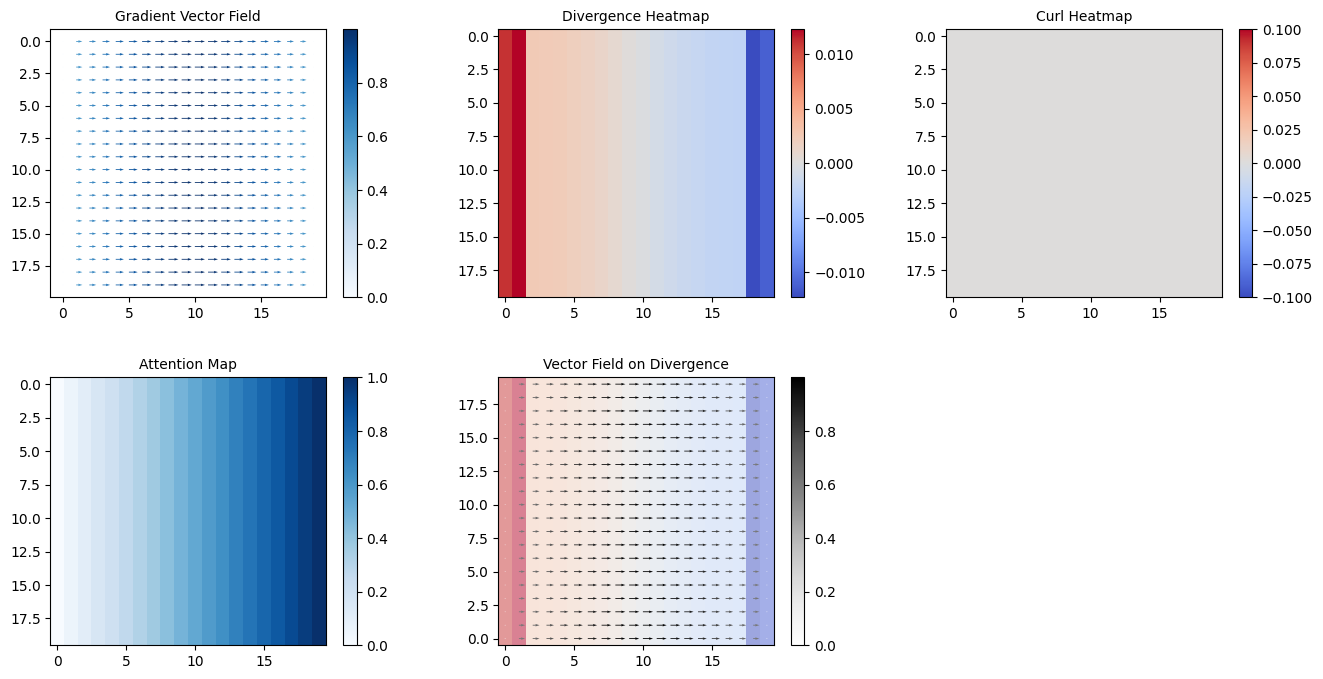

In [ ]:
grad = gradients.squeeze(0)
visualize_vector_field(grad[0], grad[1], div, curl, attn_map, step=1)

In [27]:
def generate_grid(H, W, centered=False, grid_aspect="auto"):
    """
    Generates a 2D coordinate grid with optional centering and aspect-aware normalization.
    """
    y_coords, x_coords = torch.meshgrid(torch.arange(H, dtype=torch.float32) + 0.5,
                                        torch.arange(W, dtype=torch.float32) + 0.5,
                                        indexing="ij")
    if centered:
        x_coords = x_coords - W / 2
        y_coords = y_coords - H / 2

    if grid_aspect == "equal":
        x_coords = x_coords / max(H, W)
        y_coords = y_coords / max(H, W)
    elif grid_aspect == "scaled":
        x_coords = x_coords / W
        y_coords = y_coords / H

    return torch.stack([x_coords, y_coords], dim=-1)  # Shape (H, W, 2)

# Example Usage
grid = generate_grid(4, 8, centered=False, grid_aspect="equal")  # Equal step sizes
grid_scaled = generate_grid(4, 8, centered=False, grid_aspect="scaled")  # Independent step sizes
grid_auto = generate_grid(4, 8, centered=False, grid_aspect="auto")  # No scaling


In [22]:
print(0.1875 - 0.0625)
print(0.3750 - 0.1250)

0.125
0.25


In [ ]:
# Define a guideline path (e.g., diagonal y = x)
t_steps = torch.linspace(-1, 1, steps=100)
delta_x, delta_y = get_grid_step_size(H, W, uniform=True)
x_path = t_steps * 0
y_path = t_steps * delta_y

Fx, Fy = gradients[:, 0], gradients[:, 1]  # Split into components
path_coords = torch.stack([x_path, y_path], dim=-1).view(1, -1, 1, 2)  # Shape [1, num_points, 1, 2]

# Interpolate vector field at path points
Fx_path = F.grid_sample(Fx.unsqueeze(0), path_coords, align_corners=True, mode='bilinear').squeeze()
Fy_path = F.grid_sample(Fy.unsqueeze(0), path_coords, align_corners=True, mode="bilinear").squeeze()

# Compute differentials along the path
dx = torch.gradient(x_path)[0]
dy = torch.gradient(y_path)[0]

# Compute the line integral
line_integral = torch.sum(Fx_path * dx + Fy_path * dy)

print(f"Line Integral along diagonal: {line_integral.item():.4f}")


Line Integral along diagonal: 0.0000


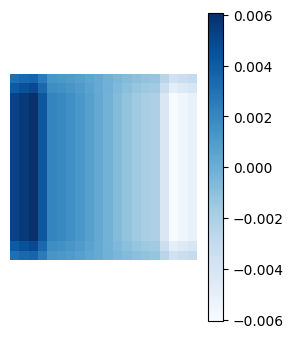

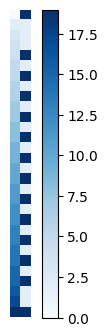

Found 30 source points and 0 sink points.


In [ ]:
import torch.nn.functional as F

# Compute divergence (replace with your computed divergence map)
# div_map = torch.randn(H, W)  # Example divergence map

# Smooth divergence to avoid noise
div_smooth = F.avg_pool2d(div.unsqueeze(0).unsqueeze(0), kernel_size=5, stride=1, padding=2).squeeze()
visualise_attn(div_smooth)

# Find local maxima (sources) and minima (sinks)
maxima = div_smooth == F.max_pool2d(div_smooth.unsqueeze(0).unsqueeze(0), kernel_size=5, stride=1, padding=2).squeeze()
minima = div_smooth == F.max_pool2d(-div_smooth.unsqueeze(0).unsqueeze(0), kernel_size=5, stride=1, padding=2).squeeze()

focal_sources = torch.nonzero(maxima)  # Points where attention is spreading out
visualise_attn(focal_sources)
focal_sinks = torch.nonzero(minima)  # Points where attention is concentrating

print(f"Found {focal_sources.shape[0]} source points and {focal_sinks.shape[0]} sink points.")


Focal strength: 1.999999761581421
Divergence: tensor([[ 4.1513e-03,  4.1427e-03, -2.2907e-05, -3.4182e-05, -4.5278e-05,
         -5.6138e-05, -6.6688e-05, -7.6890e-05, -8.6687e-05, -9.6032e-05,
         -1.0490e-04, -1.1325e-04, -1.2102e-04, -1.2822e-04, -1.3484e-04,
         -1.4087e-04, -1.4627e-04, -1.5102e-04, -3.4227e-03, -3.3461e-03],
        [ 4.1513e-03,  4.1427e-03, -2.2907e-05, -3.4182e-05, -4.5278e-05,
         -5.6138e-05, -6.6688e-05, -7.6890e-05, -8.6687e-05, -9.6032e-05,
         -1.0490e-04, -1.1325e-04, -1.2102e-04, -1.2822e-04, -1.3484e-04,
         -1.4087e-04, -1.4627e-04, -1.5102e-04, -3.4227e-03, -3.3461e-03],
        [ 4.1513e-03,  4.1427e-03, -2.2907e-05, -3.4182e-05, -4.5278e-05,
         -5.6138e-05, -6.6688e-05, -7.6890e-05, -8.6687e-05, -9.6032e-05,
         -1.0490e-04, -1.1325e-04, -1.2102e-04, -1.2822e-04, -1.3484e-04,
         -1.4087e-04, -1.4627e-04, -1.5102e-04, -3.4227e-03, -3.3461e-03],
        [ 4.1513e-03,  4.1427e-03, -2.2907e-05, -3.4182e-05, -4

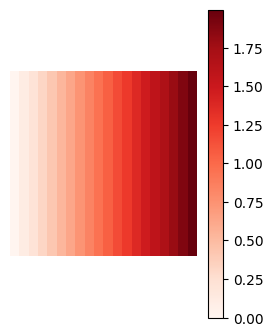

Centroid: tensor([ 3.6842e-01, -8.3447e-09])
tensor([ 3.5000e+00, -7.9274e-08])


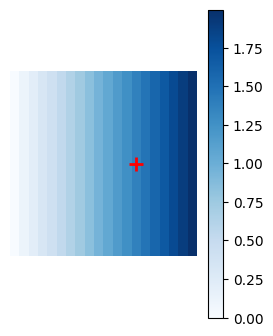

Centroid gaussian energy: 2.508763145656462e-27
Variance: tensor([10.0395,  0.3684])
Moment of inertia: 10.407894134521484
Momentum about vertical: 147.368408203125


In [ ]:
H, W = 20, 20
attn_map = generate_gradient(H=H, W=W)
attn_map = attn_map.to(dtype=torch.float32)

attn_norm = minmax_normalization(attn_map)
attn_prob = torch.sigmoid(attn_norm)
focal_strength = torch.max(attn_norm) / torch.mean(attn_norm)
print(f"Focal strength: {focal_strength}")

gradients = compute_gradients(attn_prob, filter="prewitt")
div, curl = compute_divergence_and_curl(gradients)
print(f"Divergence: {div}, Curl: {curl}")

attn_map = attn_map * focal_strength
visualise_attn(attn_map, cmap="Reds")

positions = generate_grid(H, W, normalize=True, aspect_aware=True)
attn_mass = torch.sum(attn_map)

# Compute center of mass
moments = torch.sum(attn_map.unsqueeze(-1) * positions, dim=(0,1))
centroid = moments / attn_mass
print(f"Centroid: {centroid}")

delta_x, delta_y = get_grid_step_size(H, W, uniform=True)
centroid *= delta_x
print(centroid)
center = centroid + torch.Tensor([(W - 1) / 2, (H - 1) / 2])
visualise_attn(attn_map, centroid=center)
d_VB = torch.sum(torch.abs(centroid))
e_VB = gaussian_weighting(d_VB, sigma=0.1)
print(f"Centroid gaussian energy: {e_VB}")

# Compute moment of inertia
squared_distances = torch.sum(attn_map.unsqueeze(-1) * ((positions - centroid)** 2), dim=(0, 1))
variance = squared_distances / attn_mass
print(f"Variance: {variance}")
moment_of_inertia = torch.sum(squared_distances / (H * W))
print(f"Moment of inertia: {moment_of_inertia}")

# Compute moment of inertia
vertical = get_standard_normal(type="vertical", H=H, W=W)
angular_x = torch.sum(attn_map * distance_to_line(positions, vertical, signed=True))
print(f"Momentum about vertical: {angular_x}")

